<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [283]:
import numpy as np
from sklearn.datasets import make_regression, make_classification, load_iris, load_wine, load_breast_cancer, load_diabetes, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [128]:
#X, y = make_classification(1000, 12, n_informative = 9, n_classes = 3, n_clusters_per_class = 2)
X, y = load_breast_cancer(return_X_y = True)

In [10]:
class Node():
    '''Auxilary class used for building a decision tree
    '''
    
    def __init__(self, feature, value, kind, l_answer = None, r_answer = None):
        self.feature = feature
        self.value = value
        self.kind = kind
        self.l_answer = l_answer
        self.r_answer = r_answer
    
    def split(self, left_node, right_node):
        self.left_node = left_node
        self.right_node = right_node
        if not isinstance(self.left_node, Node):
            self.l_answer = self.left_node
        if not isinstance(self.right_node, Node):
            self.r_answer = self.right_node

In [11]:
class DecisionTreeClassifier():
    '''The base class for building and utilizing a decision tree for classfification problem
    Attributes
    ----------
    max_depth : int
        Maximal depth for decision tree. Limits the growth at a given number of consecutive splits.
    criterion : str
        Type of splitting criterion to use. Availible options are 'gini' and 'entropy'.
    min_samples_leaf : int
        Minimum number of samples demanded for producing a split. If number of samples is lower than this limit,
        splitting process would be aborted.
    
    Methods
    -------
    fit(X, y)
        Fits a decision tree on a given data. Can be interpreted as learning process
    predict(X)
        Gives a prediction based on a given data
    
    
    '''
    
    
    def __init__(self, max_depth = 6, criterion = 'gini', min_samples_leaf = 2):
        '''Constructor'''
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.root_node = None

    def fit(self, X, y):
        tree = self._grow_tree(X, y, current_depth = 0)

    def predict(self, X):
        num_samples = X.shape[0]
        preds = np.empty(num_samples, dtype = np.int64)
        for sample in range(num_samples):
            preds[sample] = self._forward(X[sample])
        return preds

    def _grow_tree(self, X, y, current_depth):
        
        if X.shape[0] <= self.min_samples_leaf:
            return np.unique(y)[np.argmax(np.unique(y, return_counts = True)[1])]
        split_result = self._get_best_splits(X, y)
        if not isinstance(split_result, dict):
            return split_result
        current_node = Node(split_result['feature'], split_result['value'], split_result['kind'])
        if self.root_node is None:
            self.root_node = current_node
        current_depth = current_depth + 1
                                      
        if isinstance(split_result, dict):
    
            if current_depth > self.max_depth:
                return np.unique(y)[np.argmax(np.unique(y, return_counts = True)[1])]
    
            if split_result['kind'] == 'cat':
                X_left = X[X[:, split_result['feature']] == split_result['value']]
                X_right = X[X[:, split_result['feature']] != split_result['value']]
                y_left = y[X[:, split_result['feature']] == split_result['value']]
                y_right = y[X[:, split_result['feature']] != split_result['value']]
                current_node.split(self._grow_tree(X_left, y_left, current_depth),
                                   self._grow_tree(X_right, y_right, current_depth))
            elif split_result['kind'] == 'num':
                X_left = X[X[:, split_result['feature']] < split_result['value']]
                X_right = X[X[:, split_result['feature']] >= split_result['value']]
                y_left = y[X[:, split_result['feature']] < split_result['value']]
                y_right = y[X[:, split_result['feature']] >= split_result['value']]
                current_node.split(self._grow_tree(X_left, y_left, current_depth),
                                   self._grow_tree(X_right, y_right, current_depth))
            else:
                raise ValueError
        return current_node

    def _get_best_splits(self, X, y):
        best_split = ['', '', '']
        best_information_gain = 0
        for i in range(X.shape[1]):
            if len(np.unique(X[:, i])) < 10:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] == val]
                    y_right = y[X[:, i] != val]
                    information_gain = self._calc_information_gain(y, y_left, y_right)
                    if information_gain > best_information_gain:
                        best_information_gain = information_gain
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'cat'
            else:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] < val]
                    y_right = y[X[:, i] >= val]
                    information_gain = self._calc_information_gain(y, y_left, y_right)
                    if information_gain > best_information_gain:
                        best_information_gain = information_gain
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'num'
        if best_split[0] == '' or best_split[1] == '' or best_split[2] == '':
            return np.unique(y)[0]
        return {'feature': best_split[0], 'value': best_split[1], 'kind': best_split[2]}
        
    def _calc_information_gain(self, y, y1, y2):
        criterion = self.criterion
        if criterion == 'gini':
            information_gain = self._gini(y) - (len(y1) / len(y) * self._gini(y1) + len(y2) / len(y) * self._gini(y2))
        elif criterion == 'entropy':
            information_gain = self._entropy(y) - (len(y1) / len(y) * self._entropy(y1) + len(y2) / len(y) * self._entropy(y2))
        else:
            raise AttributeError(f'Attribute {criterion} is not allowed. Only "gini" and "entropy" are legal variants')
        return information_gain

    def _entropy(self, y):
        entropy = 0
        for i, yi in enumerate(np.unique(y, return_counts = True)[0]):
            prob = np.unique(y, return_counts = True)[1][i] / y.shape[0]
            entropy += prob * np.log2(prob)
        return -entropy

    def _gini(self, y):
        gini = 0
        for i, yi in enumerate(np.unique(y, return_counts = True)[0]):
            prob = np.unique(y, return_counts = True)[1][i] / y.shape[0]
            gini += 1 - (prob**2)
        return gini
    
    def _forward(self, X):
        answer = None
        node = self.root_node
        while answer is None:
            feature = node.feature
            value = node.value
            kind = node.kind
            if X[feature] < value:
                if node.l_answer is not None:
                    return node.l_answer
                node = node.left_node
            else:
                if node.r_answer is not None:
                    return node.r_answer
                node = node.right_node



In [258]:
class DecisionTreeRegressor():
    '''The base class for building and utilizing a decision tree for regression problem
    Attributes
    ----------
    max_depth : int
        Maximal depth for decision tree. Limits the growth at a given number of consecutive splits.
    criterion : str
        Type of splitting criterion to use. Availible options are 'MSE' and 'MAE'.
    min_samples_leaf : int
        Minimum number of samples demanded for producing a split. If number of samples is lower than this limit,
        splitting process would be aborted.
    
    Methods
    -------
    fit(X, y)
        Fits a decision tree on a given data. Can be interpreted as learning process
    predict(X)
        Gives a prediction based on a given data
    
    
    '''
    
    
    def __init__(self, max_depth = 6, criterion = 'MSE', min_samples_leaf = 2):
        '''Constructor
        '''
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.root_node = None

    def fit(self, X, y):
        tree = self._grow_tree(X, y, current_depth = 0)

    def predict(self, X):
        num_samples = X.shape[0]
        preds = np.empty(num_samples, dtype = np.float64)
        for sample in range(num_samples):
            preds[sample] = self._forward(X[sample])
        return preds

    def _grow_tree(self, X, y, current_depth):
        
        if X.shape[0] <= self.min_samples_leaf:
            return y.mean()
        split_result = self._get_best_splits(X, y)
        if not isinstance(split_result, dict):
            return split_result
        current_node = Node(split_result['feature'], split_result['value'], split_result['kind'])
        if self.root_node is None:
            self.root_node = current_node
        current_depth = current_depth + 1
                                      
        if isinstance(split_result, dict):
    
            if current_depth > self.max_depth:
                return y.mean()
    
            if split_result['kind'] == 'cat':
                X_left = X[X[:, split_result['feature']] == split_result['value']]
                X_right = X[X[:, split_result['feature']] != split_result['value']]
                y_left = y[X[:, split_result['feature']] == split_result['value']]
                y_right = y[X[:, split_result['feature']] != split_result['value']]
                current_node.split(self._grow_tree(X_left, y_left, current_depth),
                                   self._grow_tree(X_right, y_right, current_depth))
            elif split_result['kind'] == 'num':
                X_left = X[X[:, split_result['feature']] <= split_result['value']]
                X_right = X[X[:, split_result['feature']] > split_result['value']]
                y_left = y[X[:, split_result['feature']] <= split_result['value']]
                y_right = y[X[:, split_result['feature']] > split_result['value']]
                current_node.split(self._grow_tree(X_left, y_left, current_depth),
                                   self._grow_tree(X_right, y_right, current_depth))
            else:
                raise ValueError
        return current_node

    def _get_best_splits(self, X, y):
        best_split = ['', '', '']
        best_error_decrease = 0
        for i in range(X.shape[1]):
            if len(np.unique(X[:, i])) < 10:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] == val]
                    y_right = y[X[:, i] != val]
                    error_decrease = self._calc_error(y, y_left, y_right)
                    if error_decrease > best_error_decrease:
                        best_error_decrease = error_decrease
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'cat'
            else:
                for val in np.unique(X[:, i]):
                    y_left = y[X[:, i] <= val]
                    y_right = y[X[:, i] > val]
                    error_decrease = self._calc_error(y, y_left, y_right)
                    if error_decrease > best_error_decrease:
                        best_error_decrease = error_decrease
                        best_split[0] = i
                        best_split[1] = val
                        best_split[2] = 'num'
        if best_split[0] == '' or best_split[1] == '' or best_split[2] == '':
            return y.mean()
        return {'feature': best_split[0], 'value': best_split[1], 'kind': best_split[2]}
        
    def _calc_error(self, y, y1, y2):
        criterion = self.criterion
        if criterion == 'MSE':
            error = self._MSE(y) - (len(y1) / len(y) * self._MSE(y1) +  len(y2) / len(y) * self._MSE(y2))
        elif criterion == 'MAE':
            error = self._MAE(y) - (len(y1) / len(y) * self._MAE(y1) + len(y2) / len(y) * self._MAE(y2))
        else:
            raise AttributeError(f'Attribute {criterion} is not allowed. Only "gini" and "entropy" are legal variants')
        return error

    def _MSE(self, y):
        return np.var(y)

    def _MAE(self, y):
        return np.mean(np.abs(y - y.mean()))
    
    def _forward(self, X):
        answer = None
        node = self.root_node
        while answer is None:
            feature = node.feature
            value = node.value
            kind = node.kind
            if X[feature] <= value:
                if node.l_answer is not None:
                    return node.l_answer
                node = node.left_node
            else:
                if node.r_answer is not None:
                    return node.r_answer
                node = node.right_node



In [284]:
X, y = fetch_california_housing(return_X_y = True)

In [285]:
dtr = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 2, criterion = 'MSE')
dtr.fit(X, y)
mean_squared_error(y, dtr.predict(X))

C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.2571772657300517

In [275]:
answer = None
node = dtr.root_node
curr_depth = 0
while True:
    print(f'depth = {curr_depth}. condition: feature[{node.feature}] <= {node.value}')
    curr_depth += 1
    if X[0][node.feature] <= node.value:
        print('left')
        node = node.left_node
        if not isinstance(node, Node):
            print(f'result is {node}')
            break
    else:
        print('right')
        node = node.right_node
        if not isinstance(node, Node):
            print(f'result is {node}')
            break

depth = 0. condition: feature[8] <= -0.00422151393810765
right
depth = 1. condition: feature[2] <= 0.014272475267928093
right
depth = 2. condition: feature[2] <= 0.0681630789619681
left
depth = 3. condition: feature[3] <= 0.014986683562338177
right
depth = 4. condition: feature[8] <= 0.07379892880056037
left
depth = 5. condition: feature[7] <= -0.002592261998183278
left
result is 242.47058823529412


In [292]:
import pandas as pd
max_depth = 15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
dtr = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = 2, criterion = 'MSE')
dtr.fit(X_train, y_train)
Dtr = DTR(max_depth = max_depth, min_samples_leaf = 2, max_features = 1.0)
Dtr.fit(X_train, y_train)
df = pd.DataFrame(zip(y_test, dtr.predict(X_test), Dtr.predict(X_test), np.abs(dtr.predict(X_test) - Dtr.predict(X_test))))
df

C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Ilia\.conda\envs\DL_School\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,0,1,2,3
0,0.47700,0.517912,0.509024,8.888471e-03
1,0.45800,1.203000,0.719278,4.837222e-01
2,5.00001,5.000010,5.000010,8.881784e-16
3,2.18600,2.338667,2.197500,1.411667e-01
4,2.78000,2.284200,2.299000,1.480000e-02
...,...,...,...,...
4123,2.63300,2.025667,1.949667,7.600000e-02
4124,2.66800,1.952000,1.424000,5.280000e-01
4125,5.00001,4.942577,5.000010,5.743295e-02
4126,0.72300,0.638000,0.657600,1.960000e-02


In [293]:
mean_squared_error(y_test, dtr.predict(X_test)), mean_squared_error(y_test, Dtr.predict(X_test))

(0.524540631624571, 0.4312610293346321)

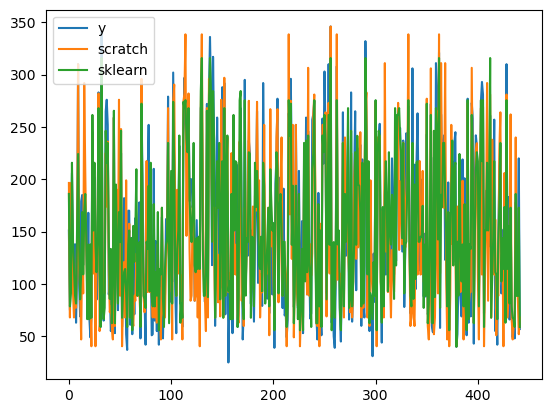

In [109]:
plt.plot(y[:500], label = 'y')
plt.plot(dtr.predict(X)[:500], label = 'scratch')
plt.plot(Dtr.predict(X)[:500], label = 'sklearn')
plt.legend()

[Text(0.44471153846153844, 0.9166666666666666, 'x[8] <= -0.004\nsquared_error = 5929.885\nsamples = 442\nvalue = 152.133'),
 Text(0.1971153846153846, 0.75, 'x[2] <= 0.006\nsquared_error = 3240.821\nsamples = 218\nvalue = 109.986'),
 Text(0.10576923076923077, 0.5833333333333334, 'x[6] <= 0.021\nsquared_error = 2143.968\nsamples = 171\nvalue = 96.31'),
 Text(0.057692307692307696, 0.4166666666666667, 'x[4] <= 0.063\nsquared_error = 2856.847\nsamples = 87\nvalue = 108.805'),
 Text(0.038461538461538464, 0.25, 'x[1] <= 0.003\nsquared_error = 2496.899\nsamples = 85\nvalue = 105.682'),
 Text(0.019230769230769232, 0.08333333333333333, 'squared_error = 2955.72\nsamples = 39\nvalue = 118.846'),
 Text(0.057692307692307696, 0.08333333333333333, 'squared_error = 1836.423\nsamples = 46\nvalue = 94.522'),
 Text(0.07692307692307693, 0.25, 'squared_error = 132.25\nsamples = 2\nvalue = 241.5'),
 Text(0.15384615384615385, 0.4166666666666667, 'x[1] <= 0.003\nsquared_error = 1076.471\nsamples = 84\nvalue = 

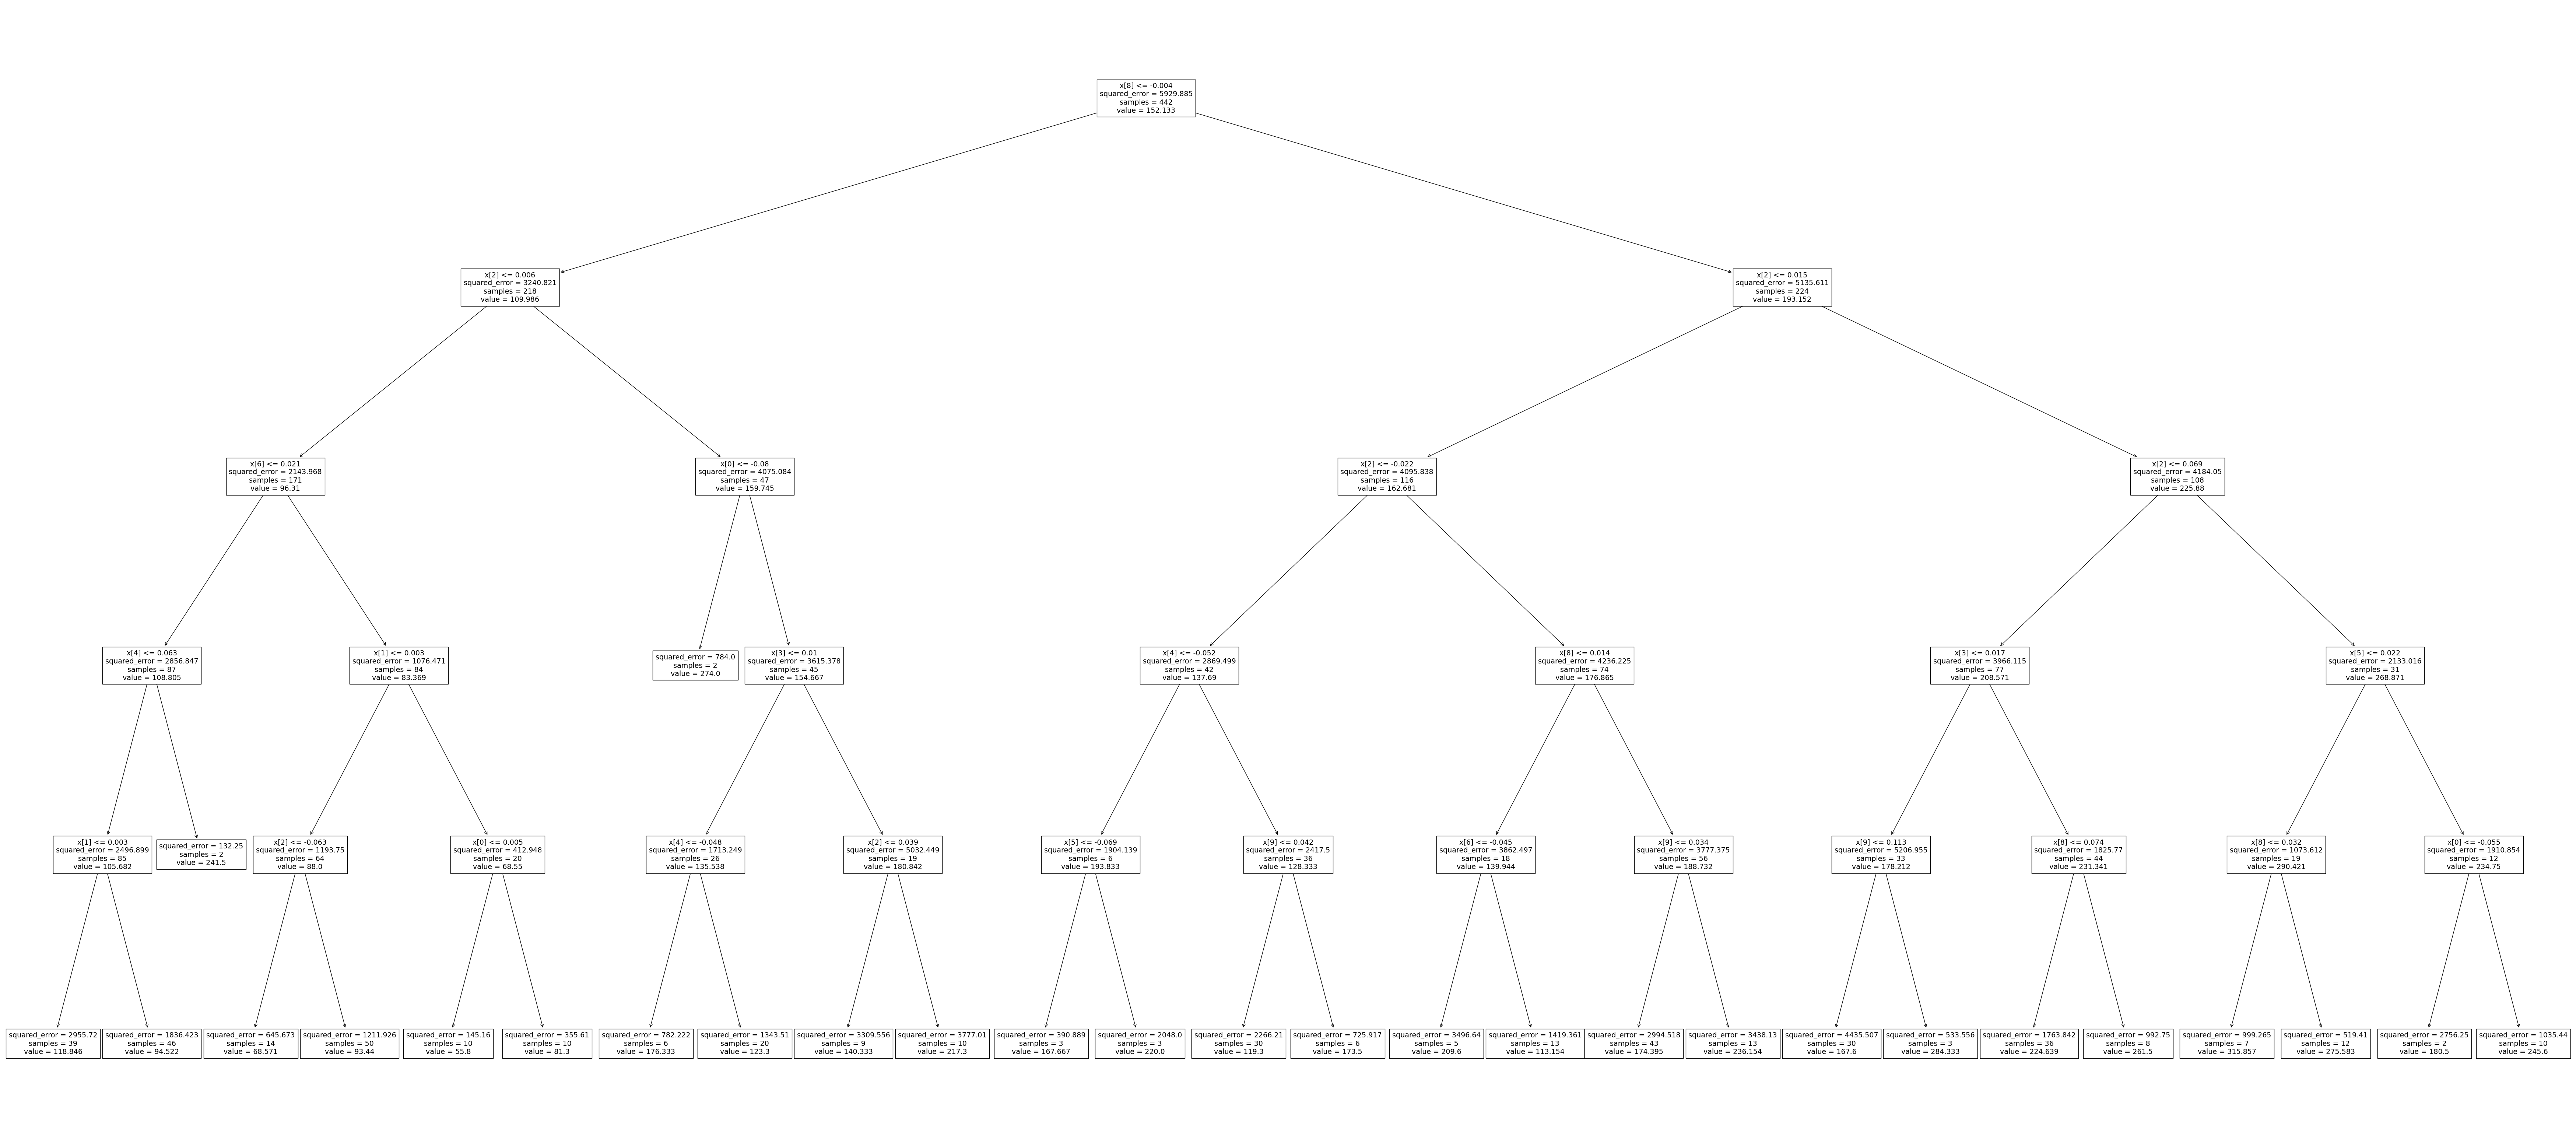

In [277]:
plt.figure(figsize = (90, 40))
plot_tree(Dtr, precision = 3)


In [242]:
Dtr = DTR(max_depth = 10, min_samples_split = 2)
Dtr.fit(X, y)
mean_squared_error(y, Dtr.predict(X))

210.4243459971401

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [153]:
dt = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy', min_samples_leaf = 2)
dt.fit(X_train, y_train)
preds = dt.predict(X_test)
print(f'f1: {f1_score(y_test, preds, average = "weighted")}')
print(f'accuracy: {accuracy_score(y_test, preds)}')

[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
f1: 0.964537136359107
accuracy: 0.9649122807017544


In [155]:
dtc = DTC(max_depth = 12, criterion = 'gini')
dtc.fit(X_train, y_train)
preds_sk = dtc.predict(X_test)
print(f1_score(y_test, preds_sk, average = 'weighted'))
print(accuracy_score(y_test, preds_sk))

0.9384499917007656
0.9385964912280702


In [149]:
dt.root_node.value

0.05182

[Text(0.5, 0.75, 'x[7] <= 0.051\ngini = 0.467\nsamples = 455\nvalue = [169, 286]'),
 Text(0.25, 0.25, 'gini = 0.107\nsamples = 282\nvalue = [16, 266]'),
 Text(0.75, 0.25, 'gini = 0.204\nsamples = 173\nvalue = [153, 20]')]

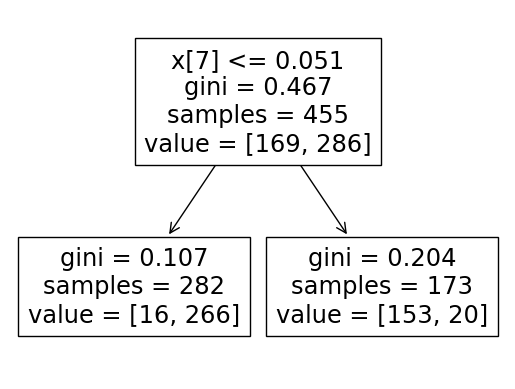

In [146]:
plot_tree(dtc)